# 07MIAR_Proyecto_Programación - Plant Seedlings Classification

### Preparación de los datos

In [ ]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/BASE_FOLDER/"
DATASET=BASE_FOLDER+ "my_dataset/ohe_data_train_resize_224.h5"

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import json
import pandas as pd

In [ ]:
df = pd.read_hdf(DATASET,key='data')



## VGG16

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

model=VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

for layer in model.layers:
    layer.trainable = False

# Agregar nuevas capas para adaptar el modelo a tu tarea
modelvgg = Sequential([
    model,
    Dense(512, activation='relu'),
    Dense(100, activation='relu'),
    Dense(12, activation='softmax')
])

# Combinar el modelo base y las nuevas capas
# model = Model(inputs=model.input, outputs=x)

modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelvgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_9 (Dense)             (None, 512)               512512    
                                                                 
 dense_10 (Dense)            (None, 100)               51300     
                                                                 
 dense_11 (Dense)            (None, 12)                1212      
                                                                 
Total params: 138922568 (529.95 MB)
Trainable params: 565024 (2.16 MB)
Non-trainable params: 138357544 (527.79 MB)
_________________________________________________________________


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Suponiendo que 'X' contiene las imágenes y 'Y' contiene las etiquetas

# Convertir X a un arreglo NumPy
X = np.array(df['imagen'].tolist())
Y = df.iloc[:, 1:]  # Selecciona todas las columnas excepto la primera (X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(3800, 224, 224, 3)
(950, 224, 224, 3)
(3800, 12)
(950, 12)


In [ ]:
import tensorflow as tf

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01 * 0.9**x)

print("[INFO] Entrenando Red Neuronal...")
history = modelvgg.fit(X_train, Y_train, epochs=15, callbacks=[reduce_lr], validation_split=0.2)

test_loss, test_acc = modelvgg.evaluate(X_test, Y_test)
print("\nTest accuracy:", test_acc)

[INFO] Entrenando Red Neuronal...
Epoch 1/15
95/95 [==============================] - 18s 176ms/step - loss: 1.7205 - accuracy: 0.4082 - val_loss: 1.3190 - val_accuracy: 0.5421 - lr: 0.0100
Epoch 2/15
95/95 [==============================] - 16s 167ms/step - loss: 1.1690 - accuracy: 0.6033 - val_loss: 1.2052 - val_accuracy: 0.5763 - lr: 0.0090
Epoch 3/15
95/95 [==============================] - 17s 183ms/step - loss: 0.9734 - accuracy: 0.6572 - val_loss: 1.1241 - val_accuracy: 0.6211 - lr: 0.0081
Epoch 4/15
95/95 [==============================] - 15s 157ms/step - loss: 0.8100 - accuracy: 0.7224 - val_loss: 1.0974 - val_accuracy: 0.6513 - lr: 0.0073
Epoch 5/15
95/95 [==============================] - 15s 159ms/step - loss: 0.6995 - accuracy: 0.7520 - val_loss: 1.1138 - val_accuracy: 0.6500 - lr: 0.0066
Epoch 6/15
95/95 [==============================] - 17s 184ms/step - loss: 0.6107 - accuracy: 0.7878 - val_loss: 1.0919 - val_accuracy: 0.6579 - lr: 0.0059
Epoch 7/15
95/95 [============

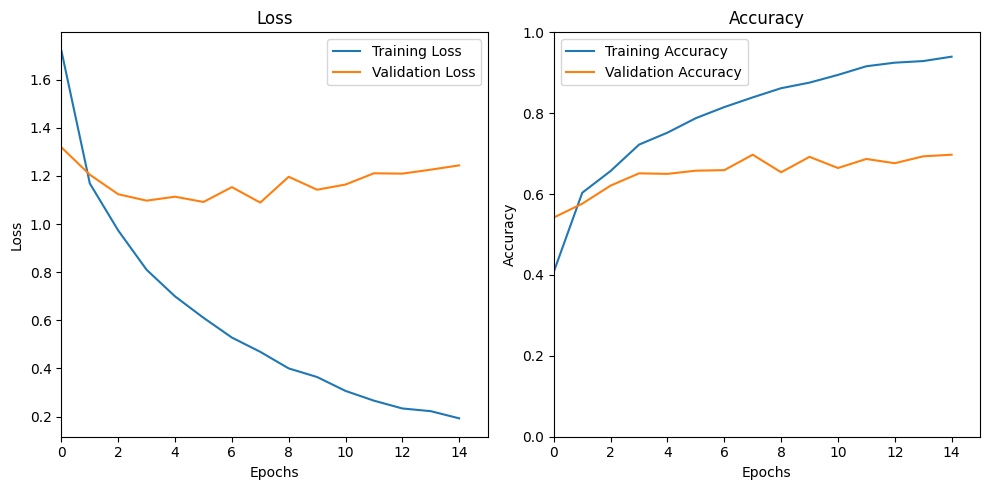

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))

    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['loss']))  # Establece límites para el eje x
    plt.legend()

    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['accuracy']))  # Establece límites para el eje x
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)